In [1]:
# MUST be executed first, as sometimes causes the kernel to die and makes it inconvinient, since everything will need to be rerun
#to create sas_models simulation with GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pyopencl as cl
import torch
cl.create_some_context()


<pyopencl.Context at 0x55dd666365e0 on <pyopencl.Device 'Quadro RTX 5000' on 'NVIDIA CUDA' at 0x55dd6619ef60>>

# Create a sphere
* specify size of a box in nm, it wil be centered around 0
* specify the resolution of the axis with nPoints - make it an odd number (if running LOCALLY, DO NOT set it bigger than 101)
* optionally specify the volume fraction, up until which the vox will be filled, default is 0.05
* call a `place_shape` function to create spheres in a box, specify `single=True` if you want to create just a single sphere
* when calling a `place_shape` you can also specify such parameters as rMean and rWidth to sample radius and length from a normal distribution with certain mean and standard deviation.  

In [30]:
from SAXSsimulations import  Sphere, Cylinder, DensityData
from SAXSsimulations.plotting import *

In [31]:
simulation = Sphere(size = 100, nPoints = 243, volFrac = 0.01)
simulation.place_shape(rMean = 3.4, nonoverlapping=False)

spheres accepted:62 and declined: 0


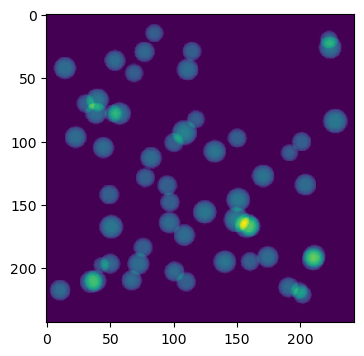

In [5]:
# the box summed on X-axis
plt.figure(figsize=(4,4))
plt.imshow(simulation.density.sum(axis=0));

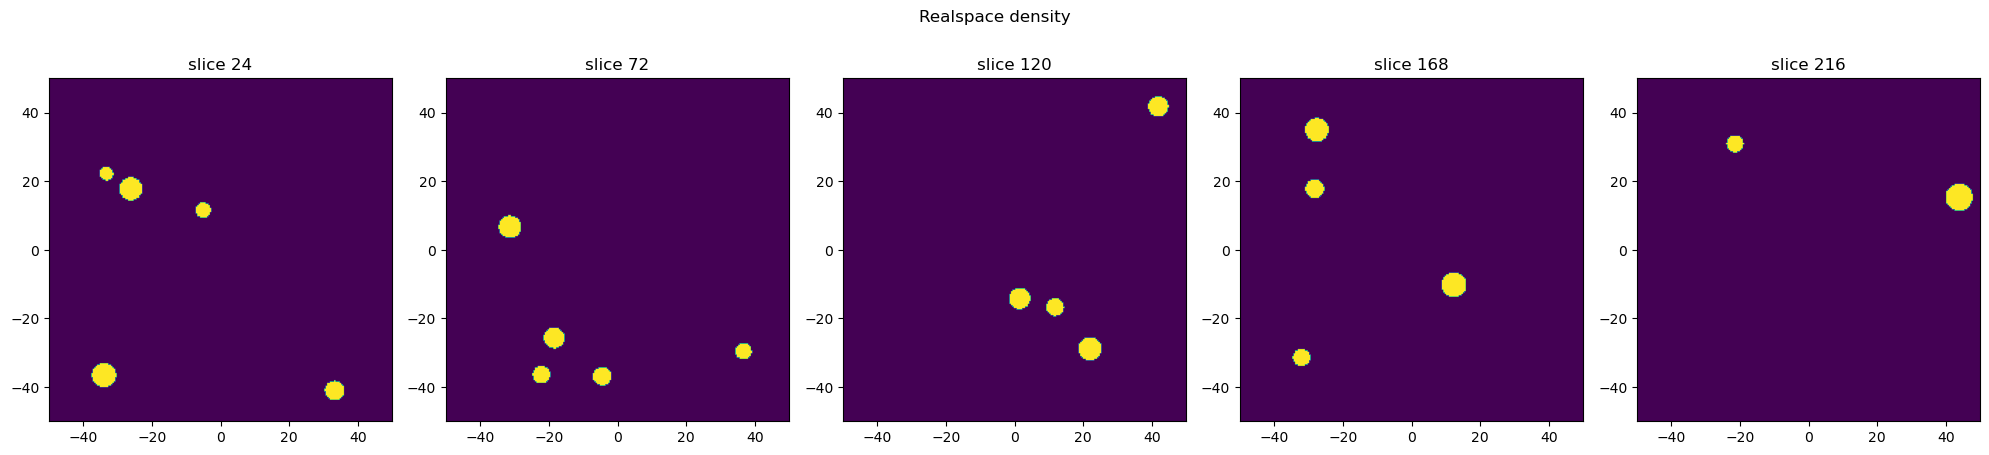

In [6]:
# plot the sampled density at 5 equally-distances slices
plot_slices(simulation.density, simulation.grid)

In [33]:
    
def plot_3D_structure(entity, grid, realspace = True, path = None):
    """ 
    plots the full 3D structure
    input: 
        entity: the 3D entity to plot
        grid: grid points of the entity to plot, used for labeling axes
        realspace[boolean]: if True considered to be density, if false, the Fourier Transform, values are log-values
        path: path to save figure 
    """
    nPoints = entity.shape[0]
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection ='3d')
    values = entity.nonzero()
    xx, yy, zz = values[:,0],values[:,1],values[:,2]
    img = ax.scatter3D(xx, yy, zz, zdir='z', c= entity[xx,yy,zz],  cmap="coolwarm" if realspace else 'Greys', s = 2, marker = 'o')
    ticks = np.linspace(0,nPoints,11)
    labels = np.round(np.linspace(grid.min(), grid.max(),11)).astype('int')  #labels = np.linspace(self.q3x.numpy().min(), self.q3x.numpy().max(),11)
    if realspace:
        img = ax.scatter3D(xx, yy, zz, zdir='z', c= entity[xx,yy,zz],  cmap="coolwarm" , s = 2, marker = 'o', vmin = 1, vmax =3)
        ax.set_xlabel(r'$X (nm)$')
        ax.set_ylabel(r'$Y (nm)$')
        ax.set_zlabel(r'$Z (nm)$')
        title = 'The density in 3D'
    else: # reciprocal
        img = ax.scatter3D(xx, yy, zz, zdir='z', c= np.log(entity[xx,yy,zz]),  cmap="Greys" , s = 2, marker = 'o')
        ax.set_xlabel('r$Q_x nm^{-1}$')
        ax.set_ylabel(r'$Q_y nm^{-1}$')
        ax.set_zlabel(r'$Q_z nm^{-1}$')
        title = 'Fourier transformed density in 3D'
        
    cbar = plt.colorbar(img, shrink = 0.8)
    cbar.set_label('log FFT')# only include colorbar when showing a FT
    ax.set_xticks(ticks, labels)
    ax.set_yticks(ticks, labels)
    ax.set_zticks(ticks, labels)
    ax.set_xlim(0,nPoints)
    ax.set_ylim(0,nPoints)
    ax.set_zlim(0,nPoints)
    if path:
        plt.savefig(path)
        plt.close()
    else:
        plt.title(title)# only set title when not saving a file
        plt.show()

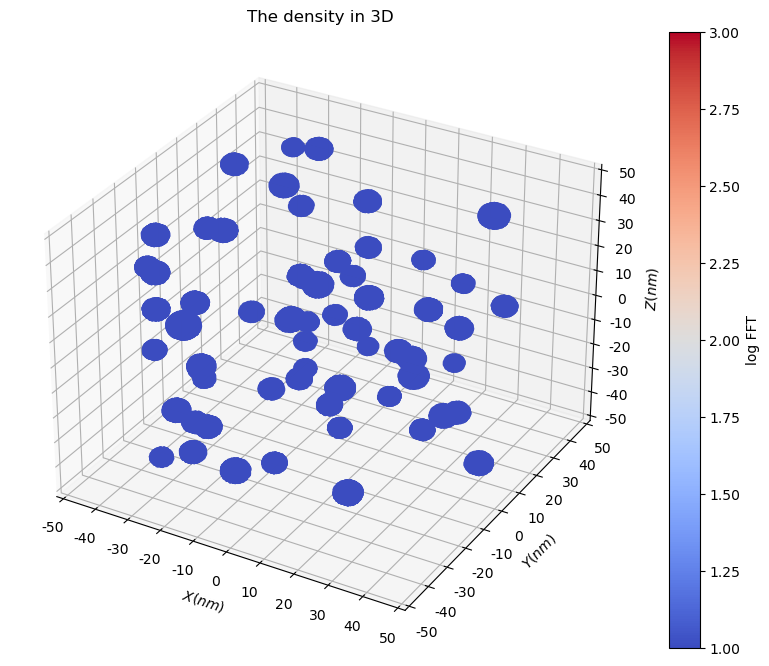

In [34]:
# takes some time
plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [35]:
# pin memory for the GPU usage
# don't need to run when no PGU available
simulation.pin_memory()

## There are few options to calculate the Fourier Transform of a structure:
1) with a class method `calculate_custom_FTI_3D_slice` - custom calculator for a central slice only
2) with a class method `calculate_custom_FTI_3D` - custom calculator for the whole 3D Fourier transform of a structure density
3) with a class method `calculate_torch_FTI_3D` - calls torch's fftn, also speciies value for a central slice as an attribute

In [6]:
# calculate FT at central slice, specify device to 'cpu' if no GPUs available
_,_ = simulation.calculate_torch_FTI(device = 'cpu') 

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [33]:
simulation.calculate_custom_FTI(three_d = False,  device = 'cuda', less_memory_use=True)

In [36]:
simulation.calculate_custom_FTI(three_d = True, device = 'cuda', less_memory_use=True)

In [6]:
a,b = simulation.calculate_custom_FTI(three_d = True, device = 'cuda', smallest_memory=True, dtype = torch.complex64)

In [ ]:
simulation.calculate_custom_FTI(three_d = False, device = 'cpu')

In [8]:
#difference in fft of central slice; only works if FTI with torch was calculated
plot_FTI_version(simulation.FTI, simulation.FTI_slice_torch, simulation.qx)

AttributeError: 'Sphere' object has no attribute 'FTI_slice_torch'

In [37]:
simulation.calculate_FTI_sinc_masked()

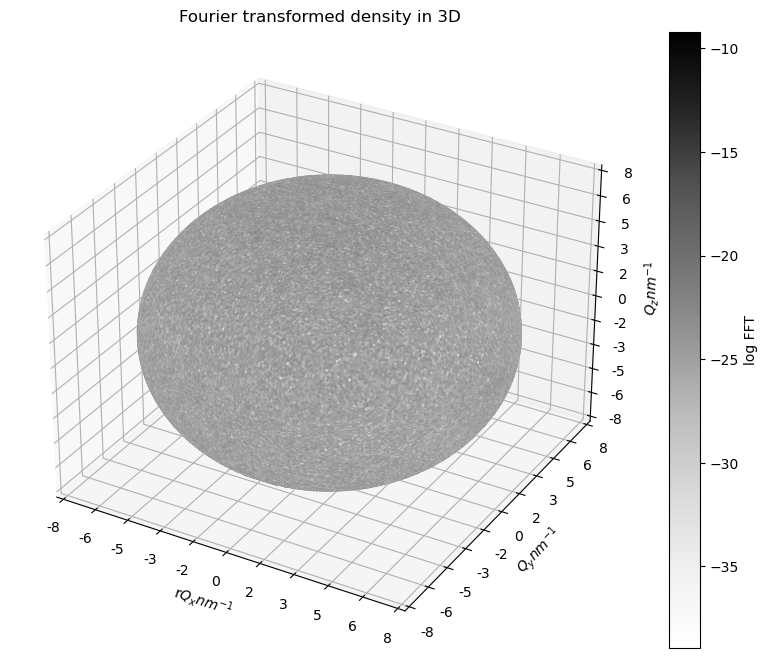

In [38]:
# don't plot on big scale, takes time!
#
plot_3D_structure(simulation.FTI_sinc_masked, simulation.qx, realspace= False)#, path = 'figures/FFT_spheres_example.png')

## The rebinning procedure. 
* before that iternally applies the sinc function
* specify the number of bins
* note, that rebinning is not performed for all calculated intensities, but only for those within the sphere inside of a box to achieve more consistent averaged values, since the "corner" values are under-represented
* after the rebinning is done, remove the very first bin, because it always contains 1 point and is the smallest possible angle, which just represents the scaling of Q 

In [39]:
def plot_simulation_vs_sas(simulation, uncertainty = 'ISigma'):
    """
    Plot Intensity I vs the scattering angle Q on log-scale for manual 3D simulation and an analytical SasModels
    input:
        simulation: a class instance with calculated attributes
        uncertainty: The value to plot as uncertainty
    """
    if simulation.shape == 'sphere':
        plt.figure(figsize = (10,10))
        print("relative error: {:.2f}".format(compute_error(simulation.I_sas, simulation.binned_slice.I.values)))
        plt.plot(simulation.qx_sas, simulation.I_sas, '-', color = 'red', label = 'SasView')
        if 'binned_slice' in dir(simulation):
            plt.plot(simulation.binned_slice.Q, simulation.binned_slice.I, color = 'blue', label = 'Simulation')
        else:
            plt.plot(simulation.binned_data.Q, simulation.binned_data.I, color = 'blue', label = 'Simulation') 
        plt.xlabel(r"q $nm^{-1}$", fontsize = 16)
        plt.ylabel(r"I $(m sr)^{-1}$", fontsize = 16)
        plt.xscale('log') 
        plt.yscale('log') 
        plt.title(r'$\chi^2$ error: {error}'.format(error = simulation.Chi_squared_norm(uncertainty) ))
        plt.legend()
    else:
        print("relative error: {:.2f}".format(compute_error(simulation.I_sas, simulation.binned_slice.I.values.reshape(simulation.nBins, simulation.nBins))))
        fig,axs = plt.subplots(1,3,figsize = (20,10))
        ax = axs[0]
        binned_FTI = simulation.binned_slice['I'].values.reshape(simulation.nBins, simulation.nBins)
        vmin = min(np.nanmin(binned_FTI),np.nanmin(simulation.I_sas))
        vmax =  max(np.nanmax(binned_FTI), np.nanmax(simulation.I_sas))
        im = ax.imshow(np.log(binned_FTI), vmin = np.log(vmin), vmax = np.log(vmax), extent = [simulation.qx.min(), simulation.qx.max(), simulation.qx.min(), simulation.qx.max()])
        ax.set_xlabel(r"q $nm^{-1}$", fontsize = 16)
        ax.set_ylabel(r"q $nm^{-1}$", fontsize = 16)
        #ax.set_title('manual simulation')
        ax = axs[1]
        im = ax.imshow(np.log(simulation.I_sas), vmin = np.log(vmin), vmax = np.log(vmax), extent = [simulation.qx.min(), simulation.qx.max(), simulation.qx.min(), simulation.qx.max()])
        ax.set_xlabel(r"q $nm^{-1}$", fontsize = 16)
        ax.set_ylabel(r"q $nm^{-1}$", fontsize = 16)
        #ax.set_title('SasModels simulation')
        ax = axs[2]
        im = ax.imshow(np.log(np.abs(binned_FTI-simulation.I_sas)) , vmin = np.log(vmin), vmax = np.log(vmax), extent = [simulation.qx.min(), simulation.qx.max(), simulation.qx.min(), simulation.qx.max()] )
        ax.set_xlabel(r"q $nm^{-1}$", fontsize = 16)
        ax.set_ylabel(r"q $nm^{-1}$", fontsize = 16)
        #ax.set_title('logged difference')
        
        cbar = plt.colorbar(im, ax = axs.ravel().tolist(), shrink=0.8, location = 'bottom',orientation='horizontal')
        cbar.set_label('log FFT')
        plt.suptitle(r'$\chi^2$ error: {error}'.format(error = simulation.Chi_squared_norm(uncertainty) ))



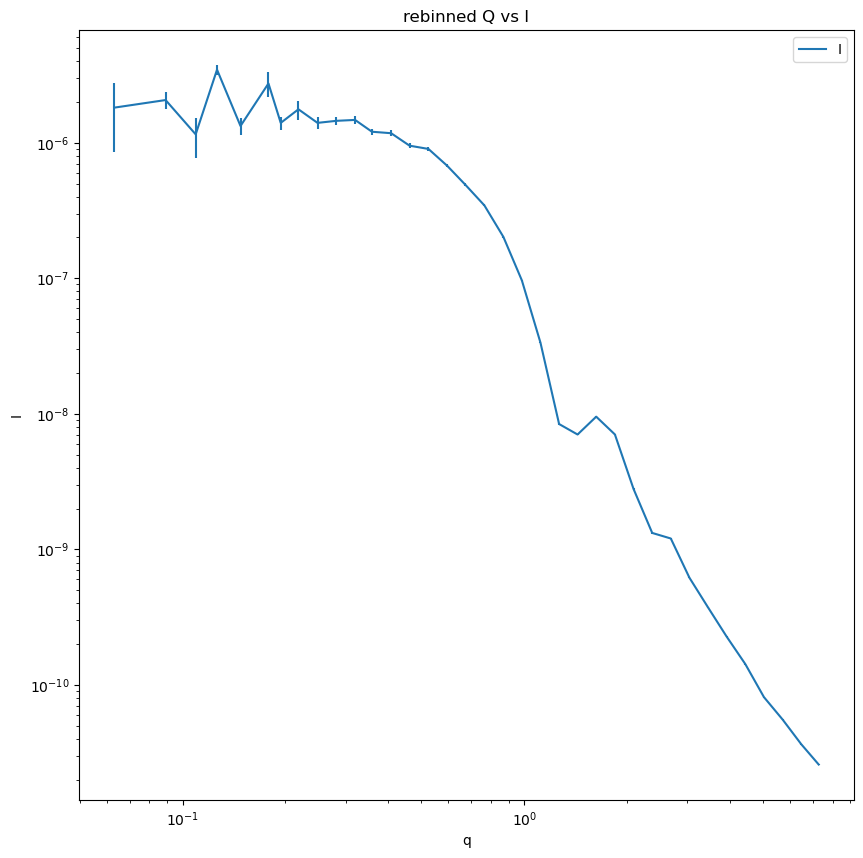

In [40]:
simulation.reBin(150, for_sas=True)
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

## Comparing to SasModels
* uses the SasModells API under the hood
* initializes the model with same values for radius and polidispersity as for simulated spheres in a box (sets background to 0, SLD to 1 and SLD solvent to 0)
* initialization is performed for same values of Q, as present after the rebinning 
* plots the comparison between Sphere simulation in a box and a SasModels simulation



relative error: 2.00


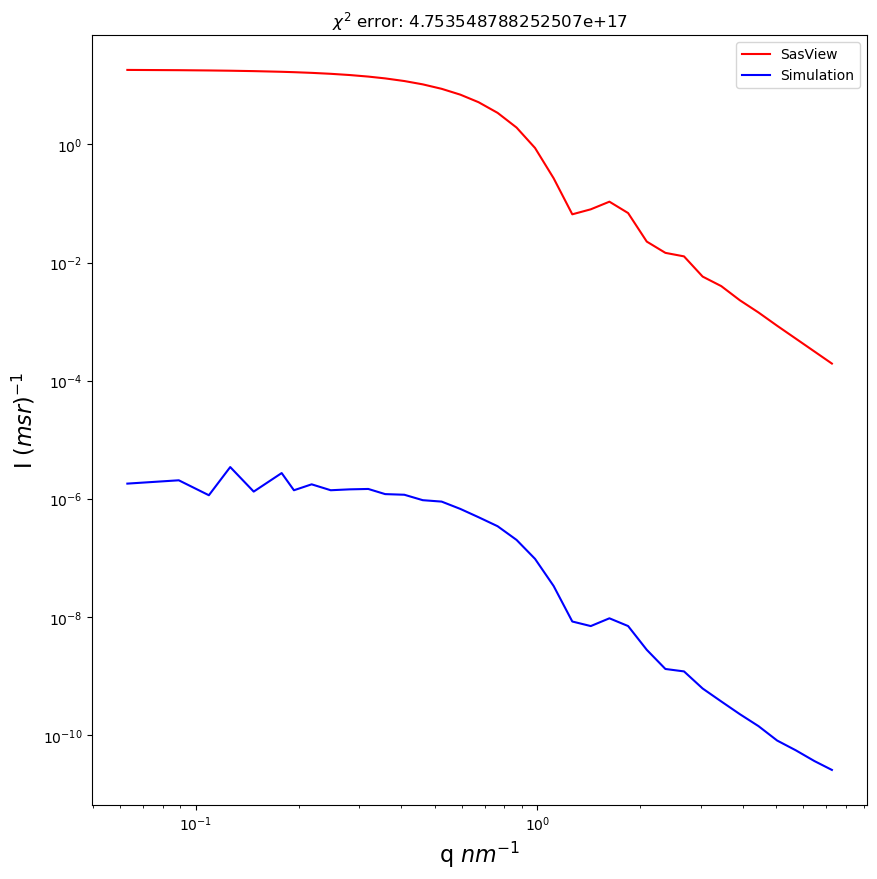

In [41]:
simulation.init_sas_model()
plot_simulation_vs_sas( simulation)

relative error: 0.58


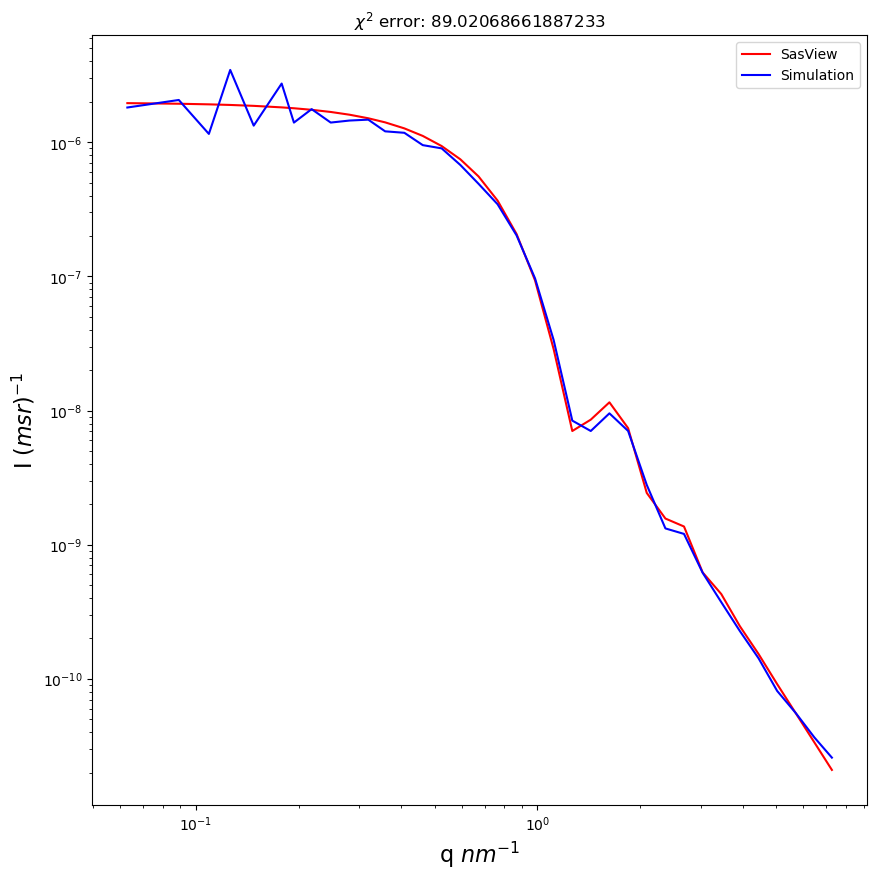

In [42]:
simulation.optimize_scaling()
plot_simulation_vs_sas( simulation)

In [ ]:
simulation.save_data(uncertainty =  'IError',directory='dat_files')
print("the sphere file with radius {r:.3f}  is saved".format(r = simulation.rMean))

the sphere file with radius 0.066  is saved


# Create a Cylinder
Similarly define the box where a cylinder will be placed and then call a function to place cylinders. One can again specify the argument to create just one cylinder, and also create cylinders of certain size by specifying rMean, hMean and rWidth hWidth to sample cylinders of certain radius and length and specifying theta and phi for the angles.
Currently creates cylinders such that one of the angles is aligned with some axis in a box.

In [21]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

simulation = Cylinder(size = 100, nPoints = 243, volFrac = 0.01)
simulation.place_shape(rMean = 1.46, hMean = 21.4, theta = 10)
print("\n{} cylinders created".format(simulation.shapes))

volume fraction is 0.01015, height is 23.012, radius is 1.468, center at (-41.0,-31.5,-41.8), rotation phi is 252, rotation theta is 16 
68 cylinders created


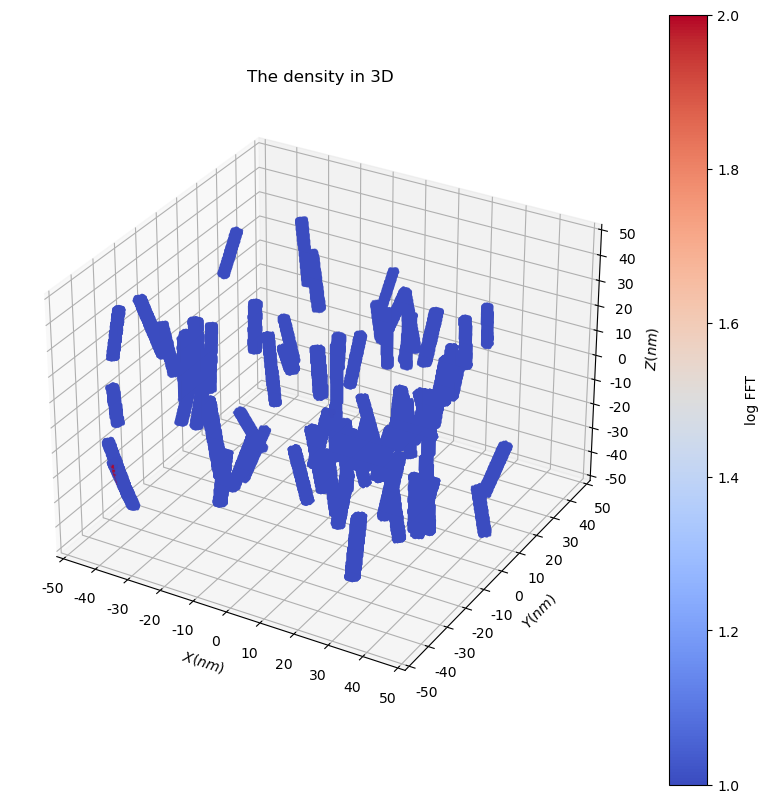

In [22]:
# takes a while 
plot_3D_structure(simulation.density, simulation.grid, realspace=True)

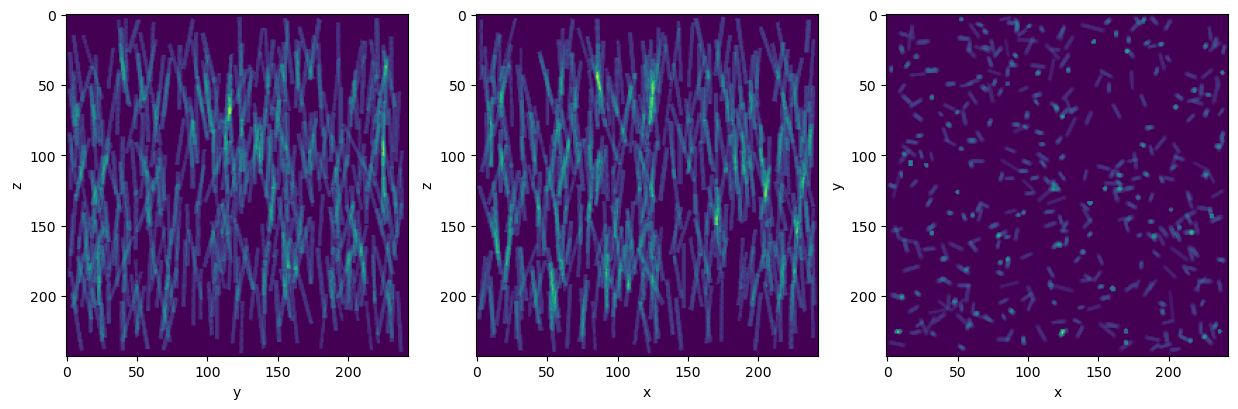

In [7]:
#plot_slices(simulation.density, simulation.grid, direction ='z')
# look at the sum on each slice
plt_slices_sum(simulation)

In [23]:
simulation.pin_memory()

compare the central slices of custom and torch's implementation

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


the maximal difference between the implementation of the FTI is 0.0044170706532895565


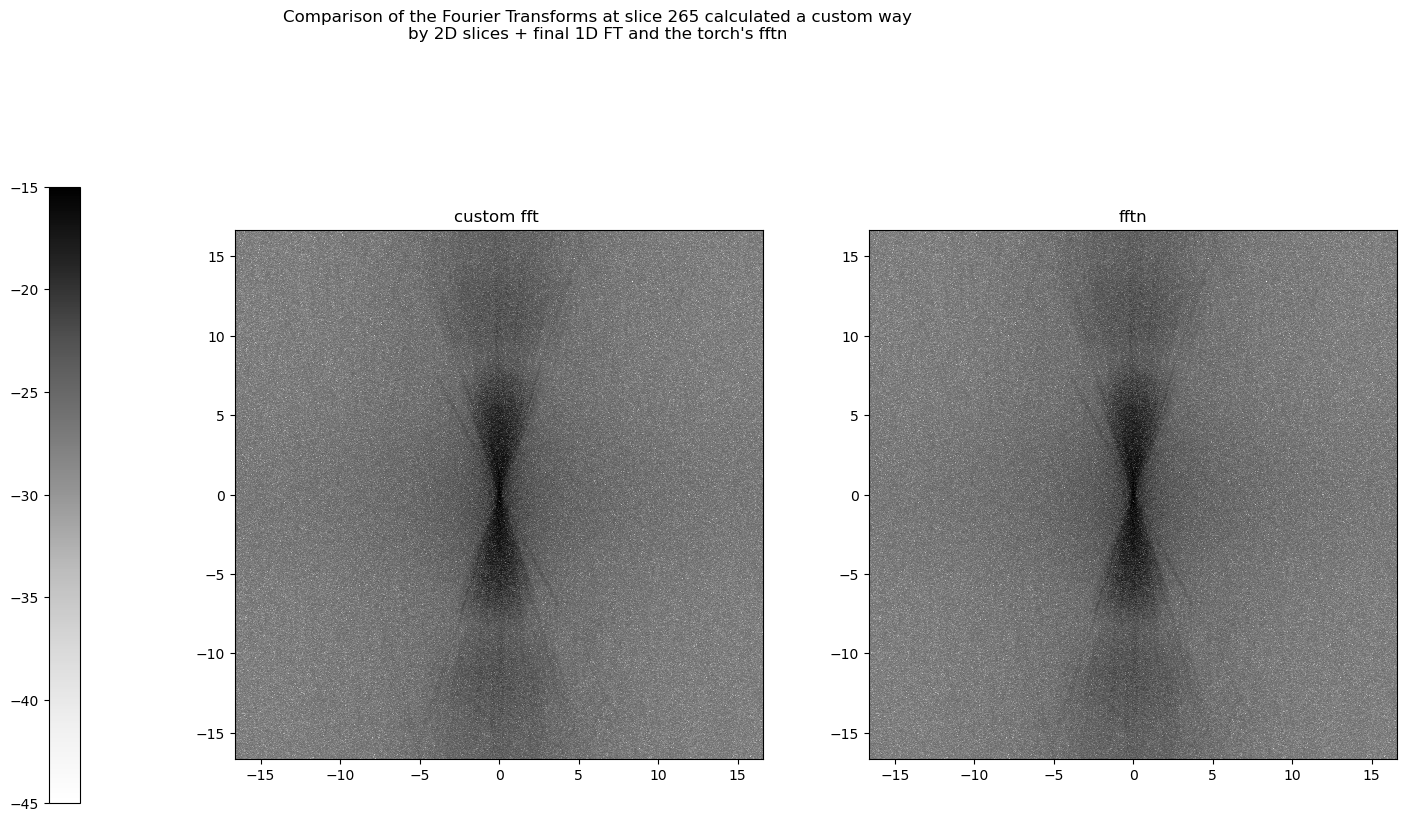

In [96]:
simulation.calculate_custom_FTI(device = 'cuda')
simulation.calculate_torch_FTI(device = 'cuda')

plot_FTI_version(simulation.FTI, simulation.FTI_slice_torch, simulation.qx)

### this function allows to look at the central slice of FT in any direction
but for it to work, we need to calculate FT for the whole box

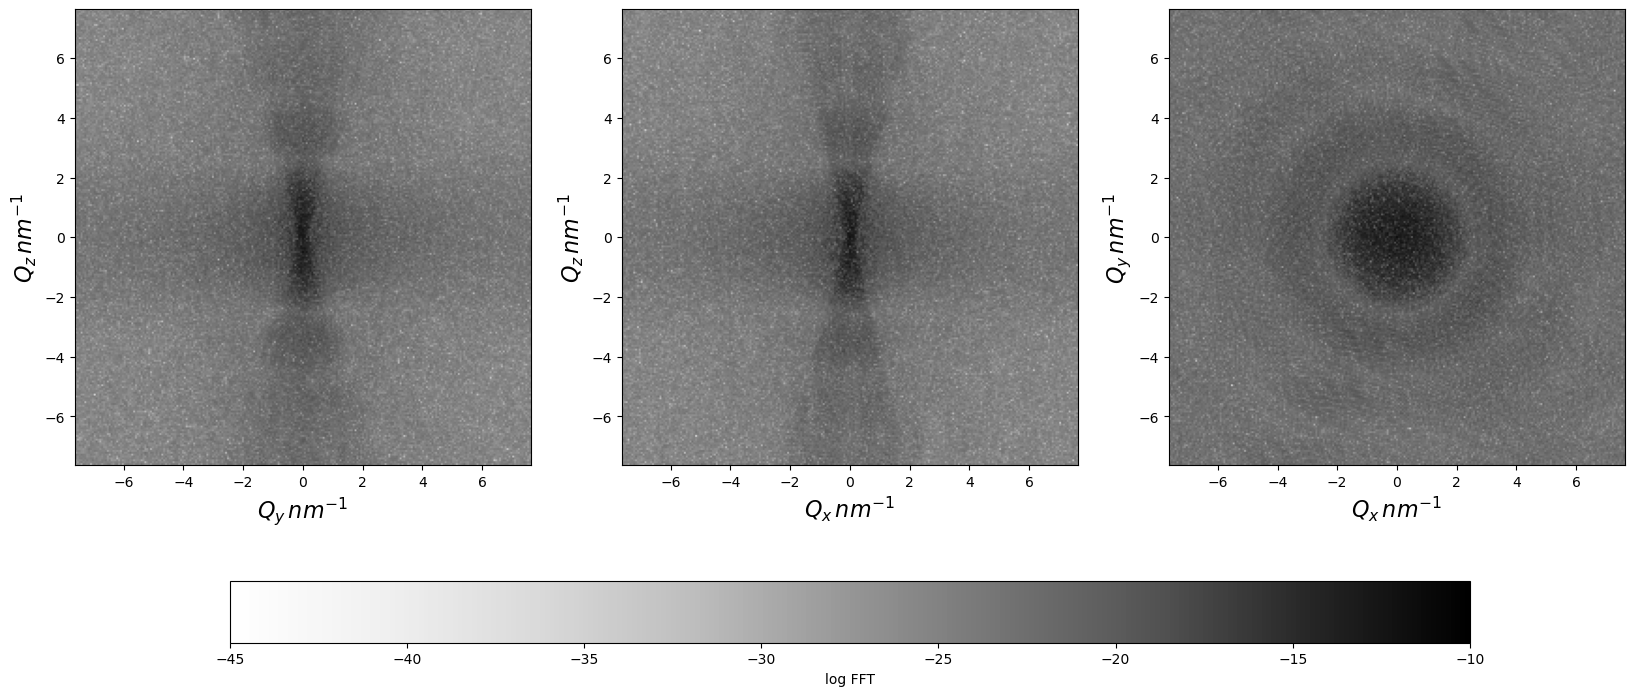

In [24]:
simulation.calculate_custom_FTI(three_d = True, device = 'cuda', less_memory_use=True)
plt_slices_ft(simulation)

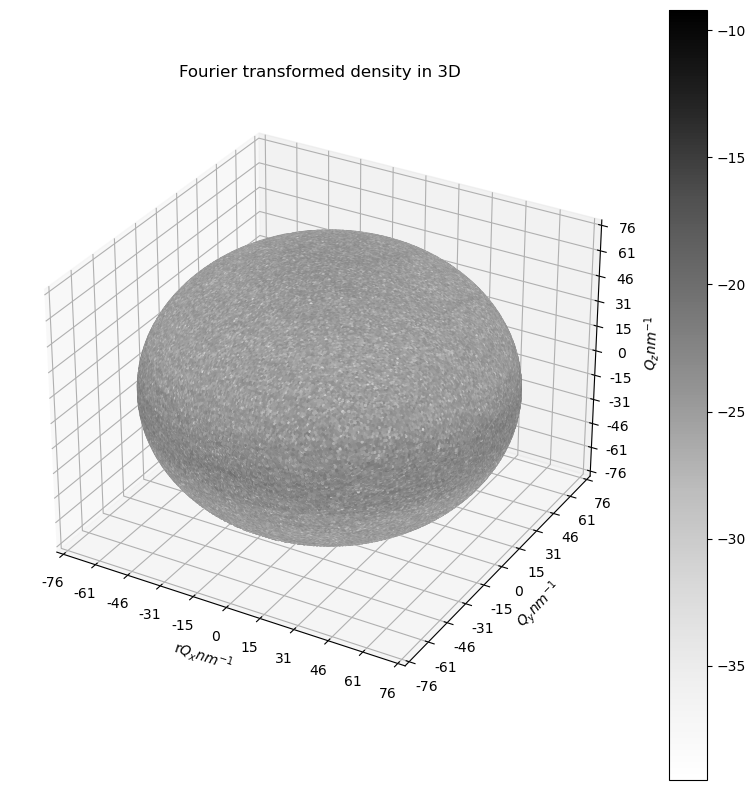

In [7]:
simulation.calculate_FTI_sinc_masked()
plot_3D_structure(simulation.FTI_sinc_masked, simulation.qx, realspace= False)

In [25]:
simulation.reBin(151)

In [26]:
simulation.init_sas_model()

In [27]:

error_init = simulation.Chi_squared_norm( 'ISigma')
print('\u03C7^2 error:', error_init)

χ^2 error: 6.07719561029642e+20


In [28]:
simulation.optimize_scaling()

relative error: 2.00


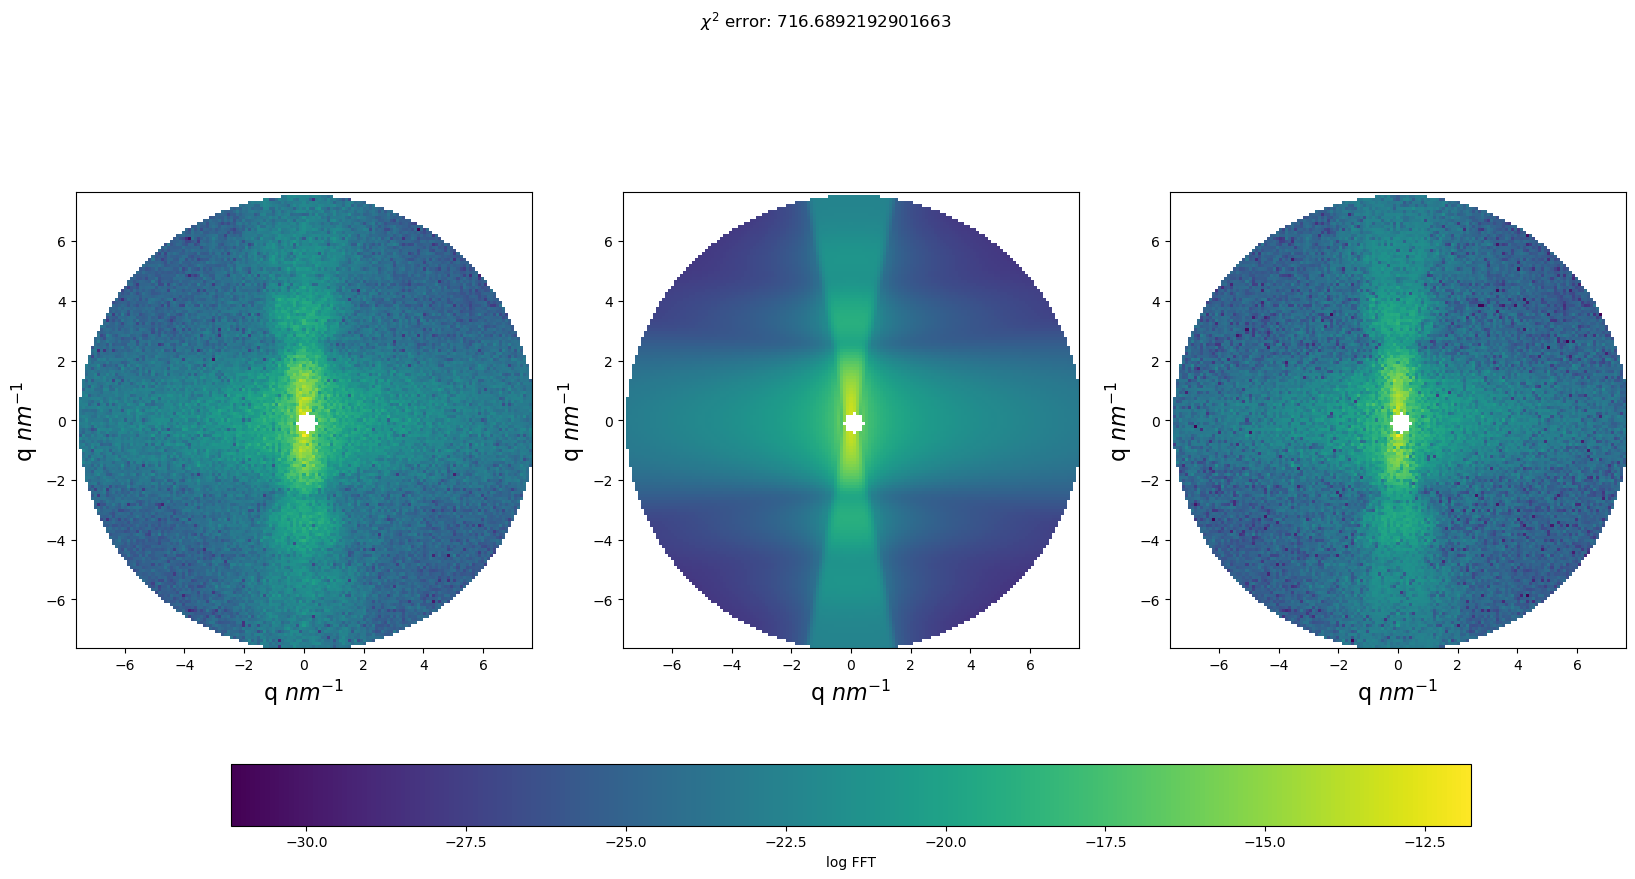

In [29]:

plot_simulation_vs_sas( simulation)

In [24]:

def plot_simulation_vs_sas(simulation, uncertainty = 'ISigma'):
    """
    Plot Intensity I vs the scattering angle Q on log-scale for manual 3D simulation and an analytical SasModels
    input:
        simulation: a class instance with calculated attributes
        uncertainty: The value to plot as uncertainty
    """
    if simulation.shape == 'sphere':
        print("relative error: {:.2f}".format(compute_error(simulation.I_sas, simulation.binned_slice.I.values)))
        plt.plot(simulation.qx_sas, simulation.I_sas, '-', color = 'red', label = 'SasView')
        if 'binned_slice' in dir(simulation):
            plt.plot(simulation.binned_slice.Q, simulation.binned_slice.I, color = 'blue', label = 'Simulation')
        else:
            plt.plot(simulation.binned_data.Q, simulation.binned_data.I, color = 'blue', label = 'Simulation') 
        plt.xlabel(r"q $nm^{-1}$")
        plt.ylabel(r"I $(m sr)^{-1}$")
        plt.xscale('log') 
        plt.yscale('log') 
        plt.title(r'$\chi^2$ error: {error}'.format(error = simulation.Chi_squared_norm(uncertainty) ))
        plt.legend()
    else:
        print("relative error: {:.2f}".format(compute_error(simulation.I_sas, simulation.binned_slice.I.values.reshape(simulation.nBins, simulation.nBins))))
        fig,axs = plt.subplots(1,3,figsize = (20,10))
        ax = axs[0]
        binned_FTI = simulation.binned_slice['I'].values.reshape(simulation.nBins, simulation.nBins)
        vmin = min(np.nanmin(binned_FTI),np.nanmin(simulation.I_sas))
        vmax =  max(np.nanmax(binned_FTI), np.nanmax(simulation.I_sas))
        im = ax.imshow(np.log(binned_FTI), vmin = np.log(vmin), vmax = np.log(vmax), extent = [simulation.qx.min(), simulation.qx.max(), simulation.qx.min(), simulation.qx.max()])
        ax.set_xlabel(r"q $nm^{-1}$")
        ax.set_ylabel(r"q $nm^{-1}$")
        ax.set_title('manual simulation')
        ax = axs[1]
        im = ax.imshow(np.log(simulation.I_sas), vmin = np.log(vmin), vmax = np.log(vmax), extent = [simulation.qx.min(), simulation.qx.max(), simulation.qx.min(), simulation.qx.max()])
        ax.set_xlabel(r"q $nm^{-1}$")
        ax.set_ylabel(r"q $nm^{-1}$")
        ax.set_title('SasModels simulation')
        ax = axs[2]
        im = ax.imshow(np.log(np.abs(binned_FTI-simulation.I_sas)) , vmin = np.log(vmin), vmax = np.log(vmax), extent = [simulation.qx.min(), simulation.qx.max(), simulation.qx.min(), simulation.qx.max()] )
        ax.set_xlabel(r"q $nm^{-1}$")
        ax.set_ylabel(r"q $nm^{-1}$")
        ax.set_title('logged difference')
        
        cbar = plt.colorbar(im, ax = axs.ravel().tolist(), shrink=0.8, location = 'bottom',orientation='horizontal')
        cbar.set_label('log FFT')
        plt.suptitle(r'$\chi^2$ error: {error}'.format(error = simulation.Chi_squared_norm(uncertainty) ))


In [16]:
binned_FTI = simulation.binned_slice['I'].values.reshape(simulation.nBins, simulation.nBins)

In [17]:
np.nanmin(binned_FTI), np.nanmin(simulation.I_sas)

(1.0402007e-14, 3.8686372e-13)

In [18]:
np.nanmax(binned_FTI), np.nanmax(simulation.I_sas)

(1.9252357e-06, 1.1547681e-06)

In [ ]:
import torch 
cuda = torch.device('cuda') 
torch.cuda.memory_stats()

{'scale': array([0.00055074]),
 'background': 0.0,
 'sld': 1.0,
 'sld_solvent': 0.0,
 'radius': 3.812304753742754,
 'length': 36.50348124070036,
 'theta': 90,
 'phi': 0,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_angle': 0.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'radius_pd': 0.2623085153458007,
 'radius_pd_type': 'gaussian',
 'radius_pd_n': 35,
 'length_pd': 0.041091971204311926,
 'length_pd_type': 'gaussian',
 'length_pd_n': 35,
 'phi_pd': 10,
 'phi_pd_type': 'uniform',
 'phi_pd_n': 35}

In [ ]:
simulation.save_data(uncertainty = 'ISigma', directory='dat_files')
print("the cylinder file with radius {r:.3f} and height {h:.3f} is saved".format(r = simulation.rMean, h = simulation.hMean))

the cylinder file with radius 0.540 and height 4.500 is saved
